## **Problema de clasificación de audio**

El problema trata de clasificar un audio intentando predecir a qué clase pertenece. Las distintas clases se dividen por la intención que tenga el usuario al hacer la consulta. En nuestro caso tenemos: `efectos_adversos` y `otros`.

---
### **Librerías**

In [112]:
# Activa inline plots
%matplotlib inline
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

import os
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import soundfile as sf
import random
from audiomentations import AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, Compose

from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestClassifier
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.calibration     import calibration_curve
from sklearn.model_selection import train_test_split


from utils_audio import (
    preprocess_audio,
    extract_zcr,
    extract_centroid_rolloff,
    extract_mfcc
)

---
### **1. Obtener dataframe con audios y clases**

In [113]:
# 1) Carpeta base donde están tus audios organizados por subcarpeta = etiqueta
AUDIO_BASE = "data/outputs/6_audio"

# 2) Ruta donde guardar el CSV (si quieres)
OUT_CSV = "data/metadata.csv"

def obtener_datos_audio():

    # Recorre las subcarpetas y recoge filename + label
    rows = []
    for label in os.listdir(AUDIO_BASE):
        class_dir = os.path.join(AUDIO_BASE, label)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(".wav"):
                    rows.append({"filename": fname, "label": label})

    # Crea el DataFrame
    df = pd.DataFrame(rows, columns=["filename", "label"])

    # (Opcional) Guardar en CSV
    os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
    df.to_csv(OUT_CSV, index=False)

    # 6) Comprueba resultado
    print(f"DataFrame con {len(df)} filas y {len(df.columns)} columnas:")
    print(df.head(5))

    return df

df = obtener_datos_audio()

DataFrame con 60 filas y 2 columnas:
                  filename             label
0        audio_8_angel.wav  efectos_adversos
1  audio_28_JoseCarlos.wav  efectos_adversos
2  audio_27_JoseCarlos.wav  efectos_adversos
3       audio_16_Pablo.wav  efectos_adversos
4        audio_5_angel.wav  efectos_adversos


---
### **2. Clasificación**
- En este caso, queremos clasificar los audios en dos clases: `efectos_adversos` y `otros`. 
- Para ello, hemos grabado 10 audios por persona y clase (`60 en total`).
- Utilizaremos el modelo `Random Forest`, ya que es un modelo con una gran capacidad de reducir la varianza, preveniendo el sobreajuste.

---
#### **2.1 Clasificación con `60 pistas` de audio**


In [114]:
# Función para obtener los dataframes de train y test a partir del CSV generado
def obtain_TR_TS_dataframes():

    # 1) Función para vectorizar un clip
    def extract_clip_features(label: str, fname: str):
        clip_path = os.path.join(AUDIO_BASE, label, fname)
        y = preprocess_audio(clip_path, reduce_noise_flag=False)
        if y is None:
            print(f"Skipping (preproc failure): {clip_path}")
            return None

        zcr = extract_zcr(y, sr=16000)
        centroid, rolloff = extract_centroid_rolloff(y, sr=16000)
        mfcc = extract_mfcc(y, sr=16000, n_mfcc=13)

        feats = []
        for arr in (zcr, centroid, rolloff):
            feats += [arr.mean(), arr.std()]
        feats += list(mfcc.mean(axis=1)) + list(mfcc.std(axis=1))

        return np.array(feats)

    # 3) Recorremos df para llenar X_list, y_list y path_list
    X_list, y_list, path_list = [], [], []
    for _, row in df.iterrows():
        feats = extract_clip_features(row["label"], row["filename"])
        if feats is not None:
            X_list.append(feats)
            y_list.append(row["label"])
            # guardamos la ruta completa (o podrías guardar solo el filename si prefieres)
            full_path = os.path.join(AUDIO_BASE, row["label"], row["filename"])
            path_list.append(full_path)

    # 4) Construimos X, y y paths
    X = np.vstack(X_list)       # shape = (n_clips, n_features)
    y = np.array(y_list)        # shape = (n_clips,)
    paths = np.array(path_list) # shape = (n_clips,)

    # 5) Ponemos todo en un DataFrame de features
    n_feats = X.shape[1]
    feat_cols = [f"feat_{i}" for i in range(n_feats)]

    df_feat = pd.DataFrame(X, columns=feat_cols)
    df_feat["filepath"] = paths
    df_feat["label"]    = y

    # 6) Split en train / test pero ahora sobre el DataFrame
    df_TR, df_TS = train_test_split(
        df_feat,
        test_size=0.2,
        stratify=df_feat["label"],
        random_state=42,
    )

    # 7) Extraemos de nuevo los arrays para tu pipeline
    X_train = df_TR[feat_cols].values
    y_train = df_TR["label"].values

    X_test  = df_TS[feat_cols].values
    y_test  = df_TS["label"].values

    return X_train, y_train, X_test, y_test, df_TR, df_TS

# Llamamos a la función para obtener los dataframes de train y test
X_train, y_train, X_test, y_test, df_TR, df_TS = obtain_TR_TS_dataframes()

In [115]:
# Función para evaluar el modelo (en train o test)
def evaluate_model(X_, y_, grid):   

    print("Mejores parámetros:", grid.best_params_)

    y_pred = grid.predict(X_)
    print(classification_report(y_, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_, y_pred))

    return y_pred

# Función para entrenar el modelo Random Forest
def train_RF(X_train, y_train):
    pipe = Pipeline(
        [("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]
    )

    param_grid = {
        "clf__n_estimators": [50, 100, 150, 200],       
        "clf__max_depth": [None, 5, 10, 15, 20, 30],    
    }

    grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    y_pred_TR = evaluate_model(X_train, y_train, grid)

    return y_pred_TR, grid

# Entrenamos el modelo Random Forest
y_pred_TR, grid = train_RF(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 150}
                  precision    recall  f1-score   support

efectos_adversos       1.00      1.00      1.00        24
           otros       1.00      1.00      1.00        24

        accuracy                           1.00        48
       macro avg       1.00      1.00      1.00        48
    weighted avg       1.00      1.00      1.00        48

Matriz de confusión:
 [[24  0]
 [ 0 24]]


##### **Evaluación del modelo**

In [116]:
y_pred_TS = evaluate_model(X_test, y_test, grid)

Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 150}
                  precision    recall  f1-score   support

efectos_adversos       0.80      0.67      0.73         6
           otros       0.71      0.83      0.77         6

        accuracy                           0.75        12
       macro avg       0.76      0.75      0.75        12
    weighted avg       0.76      0.75      0.75        12

Matriz de confusión:
 [[4 2]
 [1 5]]


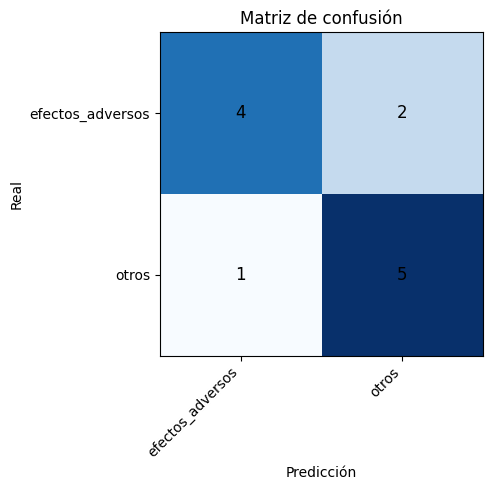

In [117]:
# Matriz de confusión
def plot_confusion_matrix(y_pred, y_label):

    labels = np.unique(np.concatenate([y_label, y_pred]))
    cm = confusion_matrix(y_label, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap='Blues')

    # Títulos y etiquetas
    ax.set_title('Matriz de confusión')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)

    # Escribe los valores en cada celda
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_pred_TS, y_test)

In [118]:
# Localizamos el audio mal clasificado
y_pred_test = grid.predict(X_test)
df_TS["y_pred"] = y_pred_test
misclasificados = df_TS[
    (df_TS["label"] == "otros") &
    (df_TS["y_pred"] == "efectos_adversos")
]
print("Falsos negativos de efectos_adversos:")
print(misclasificados[["filepath", "label", "y_pred"]])

Falsos negativos de efectos_adversos:
                                         filepath  label            y_pred
55  data/outputs/6_audio/otros/audio_18_Pablo.wav  otros  efectos_adversos


In [119]:
# Vemos el audio que se ha predicho como efectos adversos
import IPython.display as ipd
ipd.Audio(misclasificados["filepath"].values[0])

Este es el audio que ha clasificado mal como `efectos_adversos`. 

Una forma de evitar esto sería aumentar el número de audios en general, ya que actualmente solo tenemos 30 audios por clase, entonces el modelo no tiene suficiente información para aprender a clasificar correctamente. 

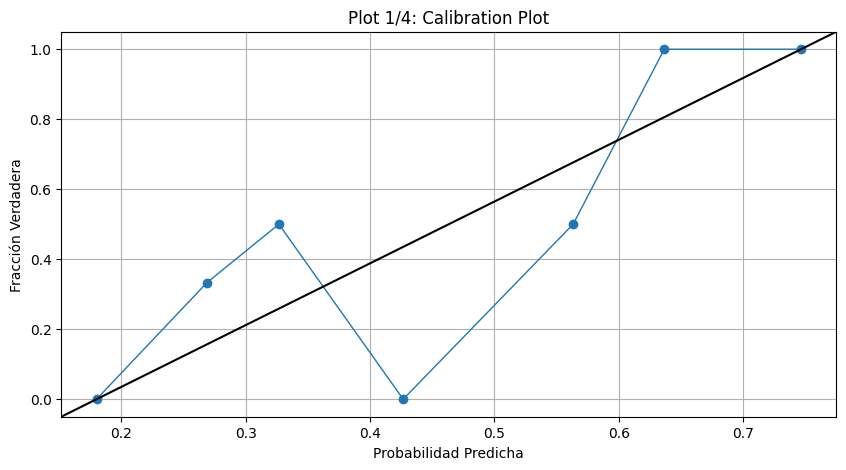

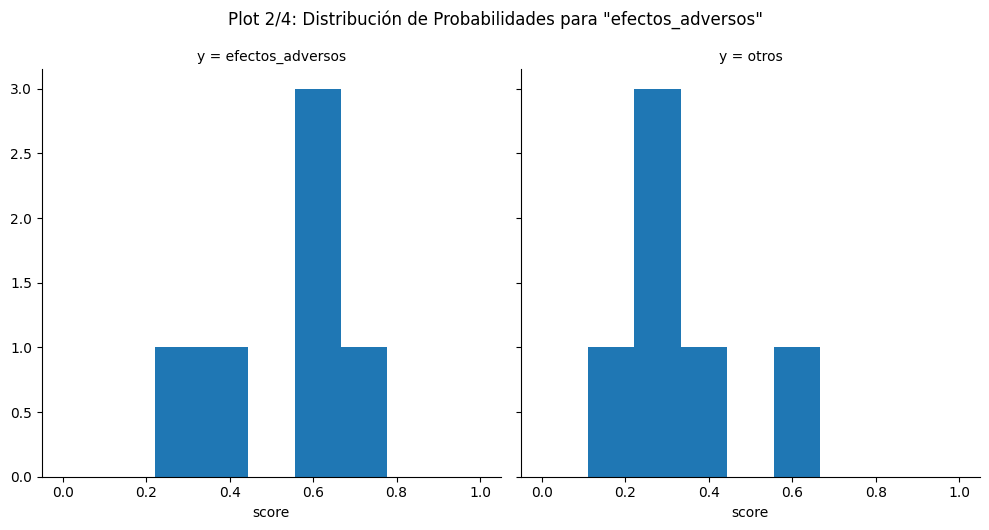

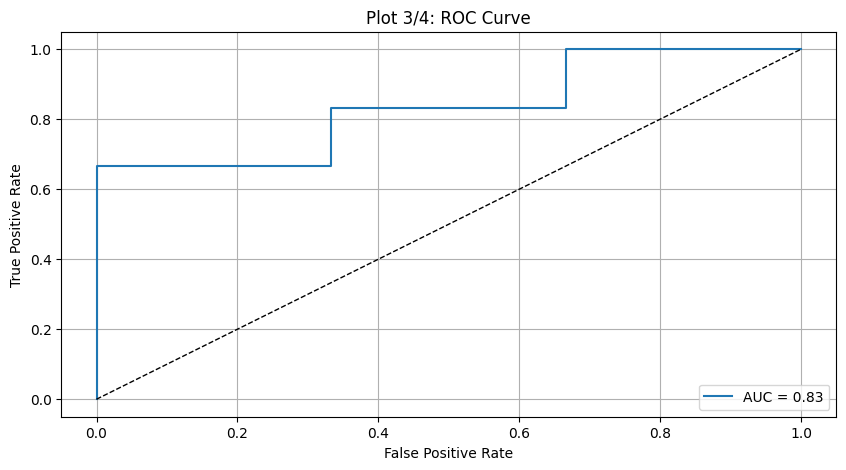

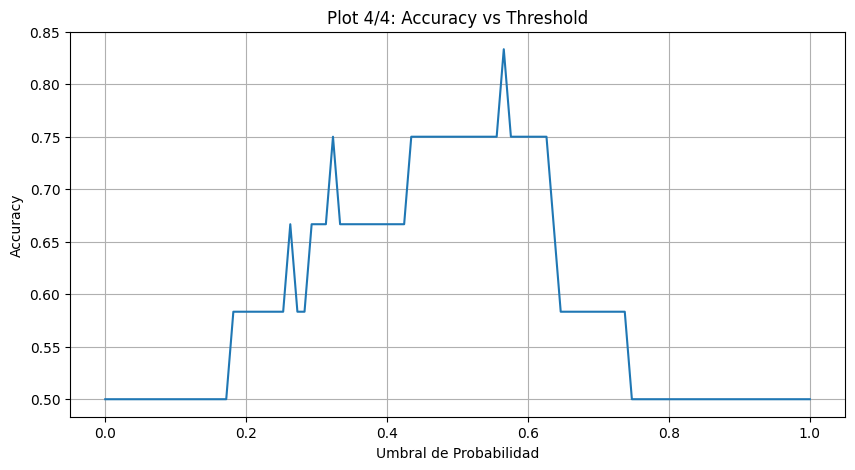

In [120]:
def plotClassPerformance(
    y: pd.Series, prob_est: np.ndarray, selClass: str = None, figsize: tuple = (10, 5)
):
    """
    Crea 4 gráficas de rendimiento de clasificación para un problema binario:
      1) Calibration plot
      2) Histograma de probabilidades
      3) ROC Curve con AUC
      4) Accuracy vs umbral

    Args:
        y (pd.Series): valores verdaderos, dtype categórico o object.
        prob_est (np.ndarray): array (n_samples, 2) de probabilidades predichas.
        selClass (str, opcional): clase positiva. Si None, toma la segunda categoría.
        figsize (tuple): tamaño de las figuras.
    """
    # Determinar categorías
    try:
        categories = y.cat.categories
    except AttributeError:
        categories = np.unique(y)
    # Seleccionar clase positiva
    if selClass is None:
        selClass = categories[1] if len(categories) > 1 else categories[0]
        warnings.warn(f'Usando "{selClass}" como clase positiva', UserWarning)
    # Índice de la clase positiva
    pos_idx = list(categories).index(selClass)

    # Binarizar y extraer score
    y_true = (y == selClass).astype(int)
    scores = prob_est[:, pos_idx]

    # 1) Calibration plot
    frac_pos, mean_pred = calibration_curve(y_true, scores, n_bins=10)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(mean_pred, frac_pos, marker="o", linewidth=1, label="Modelo")
    line = mlines.Line2D([0, 1], [0, 1], color="black", transform=ax.transAxes)
    ax.add_line(line)
    ax.set_title("Plot 1/4: Calibration Plot")
    ax.set_xlabel("Probabilidad Predicha")
    ax.set_ylabel("Fracción Verdadera")
    ax.grid(True)
    plt.show()

    # 2) Histograma de probabilidades
    df = pd.DataFrame({"y": y, "score": scores})
    g = sns.FacetGrid(
        df,
        col="y",
        sharex=True,
        height=figsize[1],
        aspect=figsize[0] / (2 * figsize[1]),
    )
    bins = np.linspace(0, 1, 10)
    g.map(plt.hist, "score", bins=bins)
    g.fig.suptitle(
        f'Plot 2/4: Distribución de Probabilidades para "{selClass}"', y=1.05
    )
    plt.show()

    # 3) ROC Curve
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0, 1], [0, 1], "k--", linewidth=1)
    ax.set_title("Plot 3/4: ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()

    # 4) Accuracy vs Threshold
    thresholds = np.linspace(0, 1, 100)
    accuracies = [accuracy_score(y_true, (scores >= t).astype(int)) for t in thresholds]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(thresholds, accuracies)
    ax.set_title("Plot 4/4: Accuracy vs Threshold")
    ax.set_xlabel("Umbral de Probabilidad")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    plt.show()

y_test_series = pd.Series(y_test, name="label")
probas = grid.best_estimator_.predict_proba(X_test)
plotClassPerformance(y_test_series, probas, selClass="efectos_adversos")

---
#### **3.2 Clasificación con `600 pistas` de audio (`Data Augmentation`)**
- Realizamos `Data Augmentation` para aumentar el número de audios. En este caso, aumentamos el número de audios a 600, es decir, 300 por clase.
- El objetivo es que el modelo tenga más información para aprender a clasificar correctamente, a ver si podemos reducir el overfitting.

In [131]:
# Lista de posibles transformaciones
ALL_TRANSFORMS = [
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1.0),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=1.0),
    PitchShift(min_semitones=-2, max_semitones=2, p=1.0),
    Shift(min_shift=-0.1, max_shift=0.1, p=1.0),
    Gain(min_gain_db=-6, max_gain_db=6, p=1.0),
]

def augment_folder_wavs_random(folder_path: str, N: int = 9, sample_rate: int = 16000):
    """
    Para cada .wav en folder_path:
      - carga la señal
      - genera N versiones aumentadas, eligiendo aleatoriamente
        un subconjunto distinto de transformaciones cada vez
      - si ya existe out_path, lo elimina primero para forzar overwrite
      - guarda el resultado en folder_path con sufijo '_augmented_i.wav'
    """
    wav_paths = glob.glob(os.path.join(folder_path, "*.wav"))
    for wav_path in wav_paths:
        y, sr = sf.read(wav_path)
        if sr != sample_rate:
            raise ValueError(f"{wav_path} tiene sr={sr}, se esperaba {sample_rate}")
        
        base, ext = os.path.splitext(os.path.basename(wav_path))
        
        for i in range(1, N+1):
            # 1) elegimos aleatoriamente cuántas y cuáles transforms aplicar
            k = random.randint(1, len(ALL_TRANSFORMS))
            chosen = random.sample(ALL_TRANSFORMS, k)
            augmenter = Compose(chosen)
            
            # 2) aplicamos augmentations
            y_aug = augmenter(samples=y.astype("float32"), sample_rate=sr)
            
            # 3) definimos ruta de salida
            out_name = f"{base}_augmented_{i}{ext}"
            out_path = os.path.join(folder_path, out_name)
            
            # 4) si existe, lo borramos para no generar copias tipo "... (1).wav"
            if os.path.exists(out_path):
                os.remove(out_path)
                print(f"[{base}] Existing file removed, will overwrite: {out_name}")
            
            # 5) escribimos el wav aumentado (sobreescribirá si ya había sido borrado)
            sf.write(out_path, y_aug, sr)
            print(f"[{base}] Saved augmented #{i} with {k} transforms → {out_name}")

# Ejemplo de uso:
#class_path = "efectos_adversos"
class_path = "otros"
augment_folder_wavs_random(
    folder_path=os.path.join("data", "outputs", "6_audio", class_path),
    N=9,
    sample_rate=16000
)

[audio_8_angel] Saved augmented #1 with 5 transforms → audio_8_angel_augmented_1.wav
[audio_8_angel] Saved augmented #2 with 2 transforms → audio_8_angel_augmented_2.wav
[audio_8_angel] Saved augmented #3 with 4 transforms → audio_8_angel_augmented_3.wav
[audio_8_angel] Saved augmented #4 with 4 transforms → audio_8_angel_augmented_4.wav
[audio_8_angel] Saved augmented #5 with 3 transforms → audio_8_angel_augmented_5.wav
[audio_8_angel] Saved augmented #6 with 2 transforms → audio_8_angel_augmented_6.wav
[audio_8_angel] Saved augmented #7 with 4 transforms → audio_8_angel_augmented_7.wav
[audio_8_angel] Saved augmented #8 with 5 transforms → audio_8_angel_augmented_8.wav
[audio_8_angel] Saved augmented #9 with 1 transforms → audio_8_angel_augmented_9.wav
[audio_28_JoseCarlos] Saved augmented #1 with 2 transforms → audio_28_JoseCarlos_augmented_1.wav
[audio_28_JoseCarlos] Saved augmented #2 with 4 transforms → audio_28_JoseCarlos_augmented_2.wav
[audio_28_JoseCarlos] Saved augmented #3 

#### **Obtener de nuevo el dataframe con los audios y clases**

In [132]:
df = obtener_datos_audio()

DataFrame con 600 filas y 2 columnas:
                              filename             label
0       audio_15_Pablo_augmented_2.wav  efectos_adversos
1  audio_22_JoseCarlos_augmented_7.wav  efectos_adversos
2       audio_18_Pablo_augmented_8.wav  efectos_adversos
3  audio_29_JoseCarlos_augmented_3.wav  efectos_adversos
4  audio_25_JoseCarlos_augmented_3.wav  efectos_adversos


In [133]:
def count_wav_files_in_folder(folder_path: str) -> int:
    """
    Cuenta el número de archivos .wav en la carpeta especificada,
    incluyendo todas las subcarpetas recursivamente.
    """
    # el patrón '**/*.wav' junto con recursive=True recorre subdirectorios
    wav_files = glob.glob(os.path.join(folder_path, '**', '*.wav'), recursive=True)
    return len(wav_files)

# Contar archivos .wav en la carpeta base
AUDIO_BASE = "data/outputs/6_audio"
print(f"Total .wav files (incluyendo subcarpetas): {count_wav_files_in_folder(AUDIO_BASE)}")

Total .wav files (incluyendo subcarpetas): 600


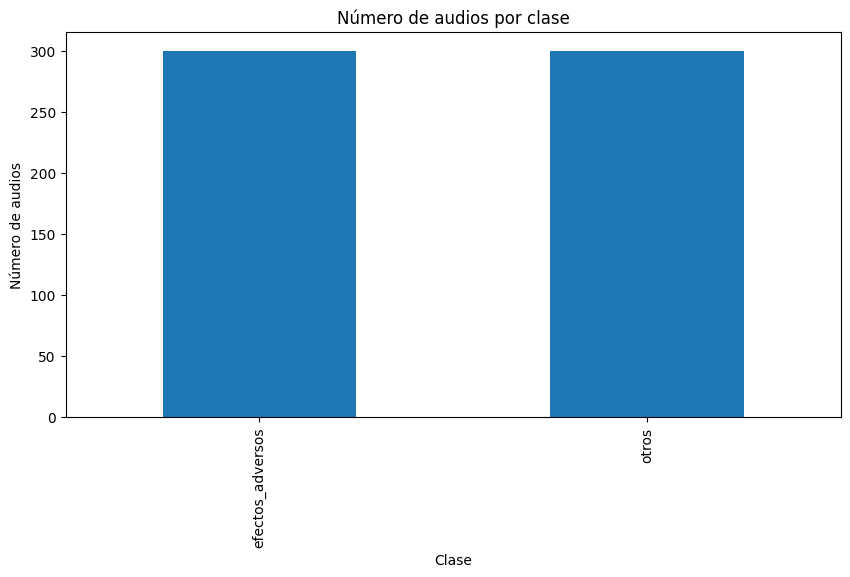

In [134]:
# Vemos el número total de audios por clase
df = pd.read_csv("data/metadata.csv")
df["label"].value_counts().plot(kind="bar", figsize=(10, 5))
plt.title("Número de audios por clase")
plt.xlabel("Clase")
plt.ylabel("Número de audios")
plt.show()

In [135]:
# Reentreamos el modelo con los audios obtenidos mediante data augmentation, a ver si se reduce el overfitting
# Llamamos a la función para obtener los dataframes de train y test
X_train, y_train, X_test, y_test, df_TR, df_TS = obtain_TR_TS_dataframes()

# Entrenamos el modelo Random Forest
y_pred_TR, grid = train_RF(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 150}
                  precision    recall  f1-score   support

efectos_adversos       1.00      1.00      1.00       240
           otros       1.00      1.00      1.00       240

        accuracy                           1.00       480
       macro avg       1.00      1.00      1.00       480
    weighted avg       1.00      1.00      1.00       480

Matriz de confusión:
 [[240   0]
 [  0 240]]


In [136]:
# Evaluamos el modelo en el conjunto de test
y_pred_test = evaluate_model(X_test, y_test, grid)

Mejores parámetros: {'clf__max_depth': None, 'clf__n_estimators': 150}
                  precision    recall  f1-score   support

efectos_adversos       0.86      0.80      0.83        60
           otros       0.81      0.87      0.84        60

        accuracy                           0.83       120
       macro avg       0.83      0.83      0.83       120
    weighted avg       0.83      0.83      0.83       120

Matriz de confusión:
 [[48 12]
 [ 8 52]]


- Como podemos ver, hacer `Data Augmentation` ha aumentado el accuracy en test (0.75 -> 0.83), reduciendo aunque no mitigando completamente el overfitting.

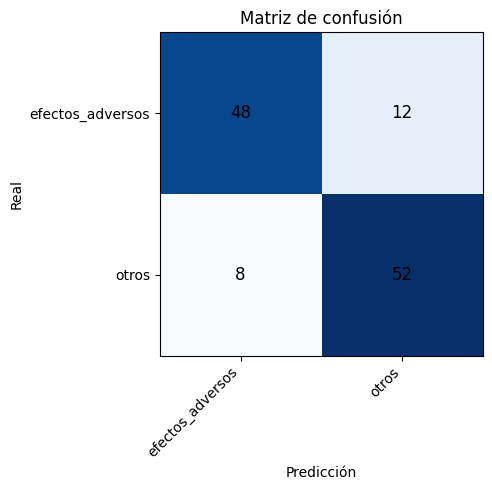

In [138]:
# Matriz de confusión
plot_confusion_matrix(y_pred_test, y_test)